In [1]:
# Import Statements

import os

import numpy as np
import pandas as pd
import math as m

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

import keras.backend as K
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.activations import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.initializers import *
from tensorflow.keras.callbacks import TensorBoard

from scipy.stats import norm

from plotting import *

np.random.seed(1)

# Generate data

In [2]:
# Data Generator Class

class DataGenerator:

    def __init__(self, NumOfSamples, TimeSteps, InitPrice, d, m, u):
        self._NumOfSamples = NumOfSamples
        self._TimeSteps = TimeSteps
        self._InitPrice = InitPrice       
        
        self._d = d
        self._m = m
        self._u = u
    

    def BS(self):
        NumOfSamples = self._NumOfSamples  
        InitPrice = self._InitPrice
        
        TimeSteps = self._TimeSteps
        
        u = self._u
        d = self._d
        m = self._m
        
        
        Z = np.random.choice([d, m, u], size = (NumOfSamples, TimeSteps))
        S = np.zeros([NumOfSamples, TimeSteps])
        S0 = InitPrice
        S[: ,0] = S0
        for t in range(1, TimeSteps):
            S[:,t] = S[: ,t - 1] * (1 + Z[:, t])
        return S

    def Data_Gen(self):
        y = self.BS()
        x = np.zeros_like(y)
        x[ : , 0] = y[ :, 0]
        x[ : , 1] = y[ :, 0]
        x[: ,2: ] = y[ : ,1:-1]
    
    # Reshape Data for LSTM (Samples, TimeSteps, Features/NumOfAssets) #

        x = x.reshape(NumOfSamples, TimeSteps, 1)
        y = y.reshape(NumOfSamples, TimeSteps, 1)

    # Split Data into train and test set #

        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

    # Set type float32 #

        x_train = x_train.astype(np.float32)
        x_test = x_test.astype(np.float32)
        y_train = y_train.astype(np.float32)
        y_test = y_test.astype(np.float32)
        return x_train, x_test, y_train, y_test

In [3]:
# Set data parameters

NumOfAssets = 1
NumOfSamples = (512 * 700 + 512 * 300)*2
TimeSteps = 30
InitPrice = 100

# S_t = S_{t-1} (1+Z)
# Z takes values d (down), m (middle) and u (up)
# -1< d < m < u

d = -0.01
m = 0.0
u = 0.01

print("Number of Samples:", NumOfSamples)

Number of Samples: 1024000


In [4]:
# Generate Data and split it (not normalized)

test = DataGenerator(NumOfSamples, TimeSteps, InitPrice, d, m, u)

x_train , x_test, y_train, y_test = test.Data_Gen()

# Loss function and metrics

In [5]:
# Customize Loss function

def loss_quantile_par(beta):
    def loss_quantile(y_true, y_pred):
        print("Lambda weight is: ", beta)
        # set price of the option to first component of y_pred
        V0 = y_pred[:, 0, 0]
        # trading strategy delta for each sample and each asset other components of y_pred
        delta = y_pred[:, 1:, :]
        # define price increments with y_true (needed for portfolio)
        price_incr = y_true[:, 1:, :] - y_true[:, :-1, :]
       
        L = tf.constant(100, dtype="float32")
        H = tf.maximum(tf.subtract(y_true[:, -1, 0], L), tf.constant(0, dtype="float32"))
   
        portfolio = tf.add(V0,
                       tf.reduce_sum(
                           tf.reduce_sum(
                               tf.multiply(delta, price_incr), axis=2), axis=1))
        # scaled sigmoid as indicator function
        indicator = tf.square(tf.nn.relu(tf.subtract(H, portfolio)))
        # factor to weight the probability of successful hedge
        beta_tf = tf.constant(beta, dtype="float32")
        # second component of loss - probability of a successful hedge
        L2 = tf.multiply(beta_tf, tf.reduce_mean(indicator))

        # first component of loss function is initial price squared
        L1 = tf.reduce_mean(tf.square(V0))
        # loss is given by the difference of initial price squared (L1) and the scaled probability of a hedge   
        L = tf.add(L1,L2)
        return L
    return loss_quantile

In [6]:
# Customize metrics

# Probability of hedge 

def prob_hedge(y_true, y_pred):
    V0 = y_pred[:, 0, 0]
    delta = y_pred[:, 1:, :]
    price_incr = y_true[:, 1:, :] - y_true[:, :-1, :]
    K = tf.constant(100, dtype ="float32")
    H_m = tf.maximum(y_true[:, -1, 0] - K, 0)
    portfolio_m = tf.add(V0,
                       tf.reduce_sum(
                           tf.reduce_sum(
                               tf.multiply(delta, price_incr), axis=2), axis=1))
    portfolio_loss = tf.where(portfolio_m >=H_m, 1.0, 0.0)
    prob_hedge = tf.reduce_mean(portfolio_loss)
    return prob_hedge


# Predicted price per epoch

def predicted_price(y_true, y_pred):
    return y_pred[0,0,0]
    

In [7]:
#put here the path to the weights folder
models_dir = os.path.abspath("weights")
if not os.path.exists(models_dir):
    os.mkdir(models_dir)


# Neural network architecture

In [8]:

# model function #
##################
def create_model(optimizer, loss, metrics):
    model = Sequential()
    model.add(LSTM(units=30,
                   return_sequences=True,
                   input_shape=(TimeSteps, NumOfAssets),
                   kernel_initializer = "TruncatedNormal",
                   bias_initializer = "TruncatedNormal"))
             
    model.add(Activation("swish"))
    model.add(LSTM(units=30, return_sequences = True,))

    model.add(Activation("swish"))

    model.add(Dense(1))
    model.add(Activation("swish"))
    model.compile(loss=loss, optimizer=optimizer, metrics = metrics)
    return model


# Quantile loss for different lambda

In [9]:
# here you define a list of different weights
# we recommend to run the learning process in a separate file for time efficiency

#indices = [10, 50, 100, 500, 1000, 2000, 4000, 10000]

#the weight 10000 is provided in the weights folder
indices = [10000]


Model_list = []
Modelfit_list = []

mod_dirs_quant = {}

[10, 50, 100, 500, 1000, 2000, 4000, 10000]


In [10]:
metrics = [prob_hedge, predicted_price]
lr = 0.0001
optimizer = Adam(lr=lr)
epochs = 40
batch_size = 1024


In [13]:


for k in range(0, len(indices), 1):
    Model_list.append(create_model(optimizer = optimizer, loss = loss_quantile_par(indices[k]), metrics = metrics))
    #Modelfit_list.append(Model_list[k].fit(x_train, y_train, epochs = epochs, batch_size = batch_size))
    l = str(indices[k])
    mod_dirs_quant["quantile_finite_"+l] = os.path.join(models_dir, "quantile_finite_"+l.h5")
    #Model_list[k].save_weights(filepath=mod_dirs_quant["quant_"+l])
    Model_list[k].load_weights(filepath = mod_dirs_quant["quantile_finite_"+l])


In [14]:
pred_par = []
for k in range(0, len(indices), 1):
    pred_par.append(Model_list[k].predict(x_test))
    

In [15]:
pred_par = np.array(pred_par)

In [17]:
print('The predicted approximate superhedging prices are:' , pred_par[:,0,0,0])

array([1.6137136, 1.8062618, 1.8600585, 1.9602915, 1.9958042, 2.041859 ,
       2.090626 , 2.1519258], dtype=float32)

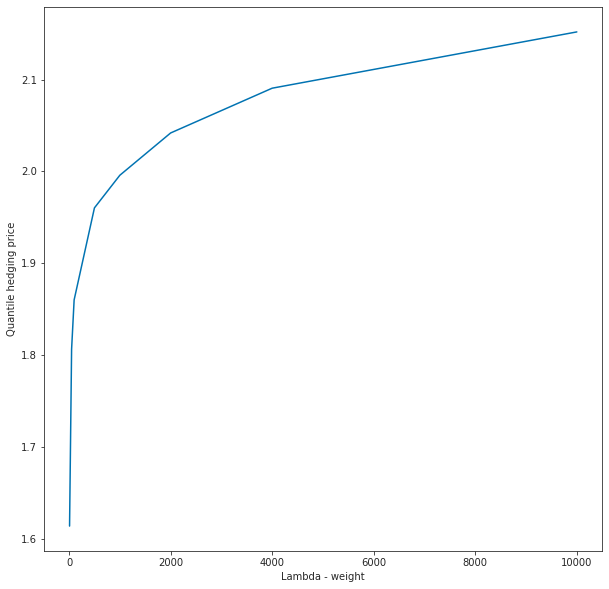

In [18]:
plt.figure(figsize = (10,10))
plt.plot(indices, pred_par[:,0,0,0])
plt.xlabel("Lambda - weight")
plt.ylabel("Quantile hedging price")

plt.show()


In [19]:
v = pred_par[:,:,0,0]

price_incr = y_test[:, 1:, :] - y_test[:, :-1, :]


port_par =  tf.add(v , tf.reduce_sum(
                           tf.reduce_sum(
                               tf.multiply(pred_par[ :, :, 1:,:], price_incr), axis=3), axis=2))

In [20]:
port_par = np.array(port_par)

In [21]:
port_par.shape

(8, 307200)

In [22]:
H_par = tf.maximum(y_test[ :, -1,0]- 100, tf.constant(0, dtype="float32"))

In [23]:
prob_par = np.array([])
for k in range(0, len(indices), 1):
    prob_par = np.append(prob_par, tf.reduce_mean(tf.where(port_par[k, :] >= H_par, 1.00, 0.00)))

In [24]:
print('The achieved superhedging probabilities are:', prob_par)

array([0.15234375, 0.55605143, 0.70749998, 0.92156577, 0.95424151,
       0.96880209, 0.98475587, 0.99237633])

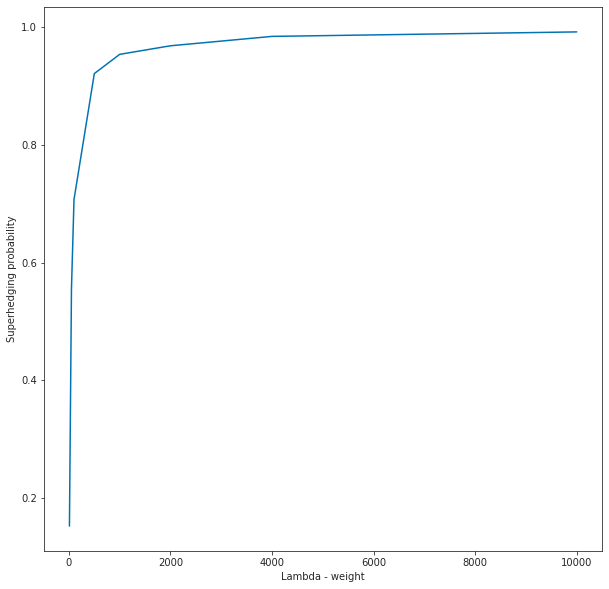

In [25]:
plt.figure(figsize = (10,10))
plt.plot(indices, prob_par)
plt.xlabel("Lambda - weight")
plt.ylabel("Superhedging probability")

plt.show()


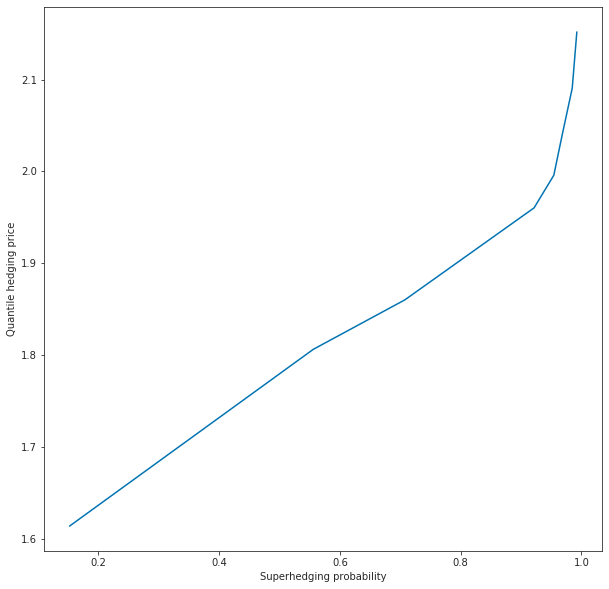

In [26]:
plt.figure(figsize = (10,10))
plt.plot(prob_par,pred_par[:,0,0,0] )
plt.xlabel("Superhedging probability")
plt.ylabel("Quantile hedging price")
+
plt.show()


In [27]:
z = np.zeros_like(port_par)

for k in range(0, len(port_par[:,0]),1):
    z[k, :] = port_par[k, : ] - H_par

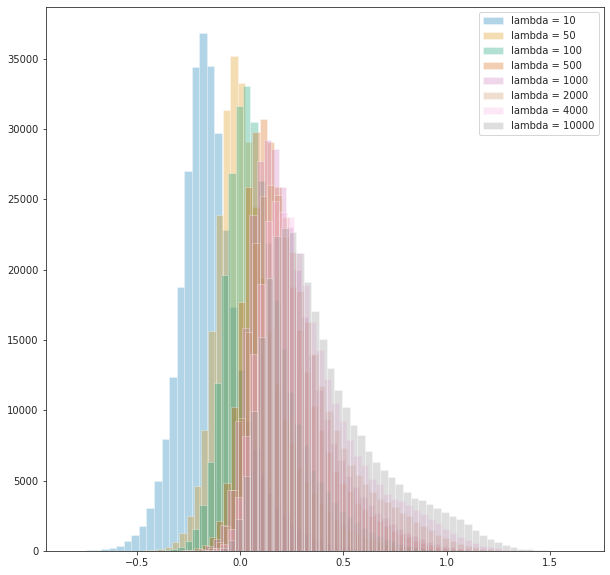

In [28]:
n_bins = 50

plt.figure(figsize = (10,10))
for k in range(0,len(port_par[:,0]),1):
    l = str(indices[k])
    z = np.zeros_like(port_par)
    z[k , : ] = np.array(port_par[k, :] - H_par)
    plt.hist(z[k, :], bins = n_bins, alpha = 0.3, label = "lambda = "+l)


plt.legend()

plt.show()